[Open in Colab](https://colab.research.google.com/drive/1Y3m3IX0PPl5-WwzSpjG55vGUeK3k35f9#scrollTo=XXwHP5gSF6aJ)

### Mount Gdrive

In [1]:
# mount gdrive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/ERA_v1/styles
!ls

/content/gdrive/MyDrive/ERA_v1/styles
learned_embeds_doodle.bin	pretrained_clip-vit-large-patch14_text_encoder
learned_embeds_kaleido.bin	pretrained_clip_vit-large-patch14_tokenizer
learned_embeds_oil_paint.bin	pretrained_stable-diffusion-v1-4_denoising_unet
learned_embeds_strip_style.bin	pretrained_stable-diffusion-v1.4.pt
learned_embeds_watercolor.bin


### Install required Libraries

In [3]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.4 MB/s eta 0:00:00


### Connect to Huggingface Hub

In [20]:
from huggingface_hub import notebook_login
notebook_login()

In [21]:

%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

### Import required libraries/modules/packages

In [22]:
from base64 import b64encode

import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel

from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os
import cv2
import torchvision.transforms as T

torch.manual_seed(1)
logging.set_verbosity_error()

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

### Load the Autoencoder!

In [23]:

# Load the autoencoder
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='vae')
# vae.save_pretrained('./pretrained_stable-diffusion-v1.4.pt')


### Load tokenizer and text encoder to tokenize and encode the text

In [24]:

# Load tokenizer and text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
# tokenizer.save_pretrained('./pretrained_clip_vit-large-patch14_tokenizer')
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
# text_encoder.save_pretrained('./pretrained_clip-vit-large-patch14_text_encoder')

### Unet model for generating latents

In [25]:

# Unet model for generating latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='unet')
# unet.save_pretrained('./pretrained_stable-diffusion-v1-4_denoising_unet')


### Noise Scheduler

In [26]:
# Noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# Move everything to GPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)


### Helper functions

1. get_output_embeds(input_embeddings): Gives the CLIP text model's causal mask embeddings.
2. set_timesteps(schedules, num_inference_steps): Prepares the scheduler to add the noise.
3. get_style_embeddings(style_file): Loads the required "style file (.bin) file" and applies the style.
4. get_EOS_pos_in_prompt(prompt): Gets the EOS tag from the prompt.
5. custom_loss(images): contians the source code for the custom loss.
6. blue_loss(images): contains the source code for the blue loss.
7. pil_to_latent(input_im): converts the PIL image to get the latents.
8. latents_to_pil(latents): converts the latents back to PIL image.
9. additional_guidance(latents, scheduler, noise_pred, t, sigma, custom_loss_fn, custom_loss_scale): Helper function to add custom_loss_funtion.
10. generate_with_embs(text_embeddings, max_length, random_seed, loss_fn = None, custom_loss_scale=1.0): Generates the images using embeddings.
11. generate_image_with_custom_style(prompt, style_num=None, random_seed=41, custom_loss_fn = None, custom_loss_scale=1.0): Takes a custom style file and generates the images (in the given sytle with custom_loss_function)
12. show_images(images_list): Shows the list of images.

In [27]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [28]:

# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

In [29]:
style_files = [None, 'learned_embeds_doodle.bin', 'learned_embeds_oil_paint.bin', 'learned_embeds_thumbsup.bin',
               'learned_embeds_kaleido.bin', 'learned_embeds_strip_style.bin', 'learned_embeds_watercolor.bin']

In [30]:
def get_style_embeddings(style_file):
  style_embed = torch.load(style_file)
  style_name = list(style_embed.keys())[0]
  return style_embed[style_name]

def get_EOS_pos_in_prompt(prompt):
  return len(prompt.split()) + 1

In [31]:
def custom_loss(images):
  pass



def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return error

In [32]:
from torchvision.transforms import ToTensor
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def additional_guidance(latents, scheduler, noise_pred, t, sigma, custom_loss_fn, custom_loss_scale):
    #### ADDITIONAL GUIDANCE ###
    # Requires grad on the latents
    latents = latents.detach().requires_grad_()

    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred
    #print(f"latents: {latents.shape}, noise_pred:{noise_pred.shape}")
    #latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

    # Decode to image space
    denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

    # Calculate loss
    loss = custom_loss_fn(denoised_images) * custom_loss_scale

    # Get gradient
    cond_grad = torch.autograd.grad(loss, latents, allow_unused=False)[0]

    # Modify the latents based on this gradient
    latents = latents.detach() - cond_grad * sigma**2
    return latents, loss


def generate_with_embs(text_embeddings, max_length, random_seed, loss_fn = None, custom_loss_scale=1.0):

    generator = torch.manual_seed(random_seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        if loss_fn is not None:
            if i%2 == 0:
                latents, custom_loss = additional_guidance(latents, scheduler, noise_pred, t, sigma, loss_fn, custom_loss_scale)
                print(i, 'loss:', custom_loss.item())

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [33]:
def generate_image_with_custom_style(prompt, style_num=None, random_seed=41, custom_loss_fn = None, custom_loss_scale=1.0):
    eos_pos = get_EOS_pos_in_prompt(prompt)

    style_token_embedding = None
    if style_num:
        style_token_embedding = get_style_embeddings(style_files[style_num])

    # tokenize
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    max_length = text_input.input_ids.shape[-1]
    input_ids = text_input.input_ids.to(torch_device)

    # get token embeddings
    token_emb_layer = text_encoder.text_model.embeddings.token_embedding
    token_embeddings = token_emb_layer(input_ids)

    # Append style token towards the end of the sentence embeddings
    if style_token_embedding is not None:
        token_embeddings[-1, eos_pos, :] = style_token_embedding

    # combine with pos embs
    pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
    position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
    position_embeddings = pos_emb_layer(position_ids)
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And generate an image with this:
    generated_image = generate_with_embs(modified_output_embeddings, max_length, random_seed, custom_loss_fn, custom_loss_scale)
    return generated_image


In [34]:
def show_images(images_list):
    # Let's visualize the four channels of this latent representation:
    fig, axs = plt.subplots(1, len(images_list), figsize=(16, 4))
    for c in range(len(images_list)):
        axs[c].imshow(images_list[c])
    plt.show()


In [35]:
# styles_files.
style_files.remove('learned_embeds_thumbsup.bin')
style_files

[None,
 'learned_embeds_doodle.bin',
 'learned_embeds_oil_paint.bin',
 'learned_embeds_kaleido.bin',
 'learned_embeds_strip_style.bin',
 'learned_embeds_watercolor.bin']

### Images Generation

0 None


<ipython-input-14-edcdebd8c7d6>:60: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 57.64173126220703
2 loss: 16.464826583862305
4 loss: 7.355838298797607
6 loss: 4.915119647979736
8 loss: 4.115111351013184
10 loss: 3.554816961288452
12 loss: 3.0548644065856934
14 loss: 2.6794652938842773
16 loss: 2.4747438430786133
18 loss: 2.4758248329162598
20 loss: 2.432102918624878
22 loss: 2.3879950046539307
24 loss: 2.306952714920044
26 loss: 2.236788272857666
28 loss: 2.2341384887695312
1 learned_embeds_doodle.bin


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 57.259666442871094
2 loss: 15.996249198913574
4 loss: 17.201313018798828
6 loss: 15.155259132385254
8 loss: 13.27241039276123
10 loss: 14.97596549987793
12 loss: 13.968306541442871
14 loss: 12.974041938781738
16 loss: 13.368124008178711
18 loss: 13.086859703063965
20 loss: 12.956083297729492
22 loss: 12.857945442199707
24 loss: 12.827324867248535
26 loss: 12.840947151184082
28 loss: 12.990272521972656
2 learned_embeds_oil_paint.bin


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 30.380416870117188
2 loss: 14.532010078430176
4 loss: 6.58359956741333
6 loss: 3.966279983520508
8 loss: 2.8843369483947754
10 loss: 2.5805468559265137
12 loss: 3.2078287601470947
14 loss: 3.0254809856414795
16 loss: 2.9255330562591553
18 loss: 3.0462796688079834
20 loss: 3.024423360824585
22 loss: 3.058396100997925
24 loss: 3.179564952850342
26 loss: 3.3720619678497314
28 loss: 3.644096851348877
3 learned_embeds_kaleido.bin


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 64.38690948486328
2 loss: 14.32654857635498
4 loss: 11.779132843017578
6 loss: 10.202497482299805
8 loss: 12.147064208984375
10 loss: 9.402273178100586
12 loss: 8.204743385314941
14 loss: 7.851898670196533
16 loss: 7.6989665031433105
18 loss: 7.471555709838867
20 loss: 7.3668212890625
22 loss: 7.314250469207764
24 loss: 7.357511520385742
26 loss: 7.395417213439941
28 loss: 7.514390468597412
4 learned_embeds_strip_style.bin


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 54.98956298828125
2 loss: 11.658653259277344
4 loss: 13.56103229522705
6 loss: 15.246129035949707
8 loss: 9.70430850982666
10 loss: 8.912688255310059
12 loss: 8.008187294006348
14 loss: 7.305481910705566
16 loss: 7.099421501159668
18 loss: 6.839449882507324
20 loss: 6.670001029968262
22 loss: 6.622707843780518
24 loss: 6.62789249420166
26 loss: 6.659790992736816
28 loss: 6.757329940795898
5 learned_embeds_watercolor.bin


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 62.019874572753906
2 loss: 14.26568603515625
4 loss: 7.426390171051025
6 loss: 5.5937724113464355
8 loss: 4.273768424987793
10 loss: 5.4705491065979
12 loss: 5.2319536209106445
14 loss: 5.233237266540527
16 loss: 5.728562831878662
18 loss: 5.510226726531982
20 loss: 5.6328630447387695
22 loss: 5.732659339904785
24 loss: 5.799158096313477
26 loss: 5.875554084777832
28 loss: 6.01970100402832


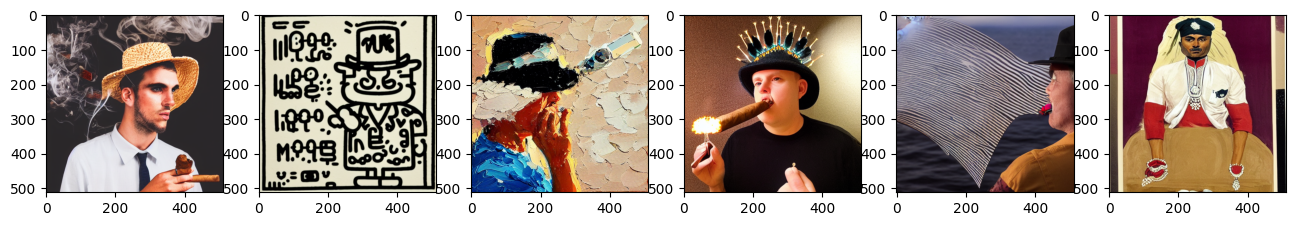

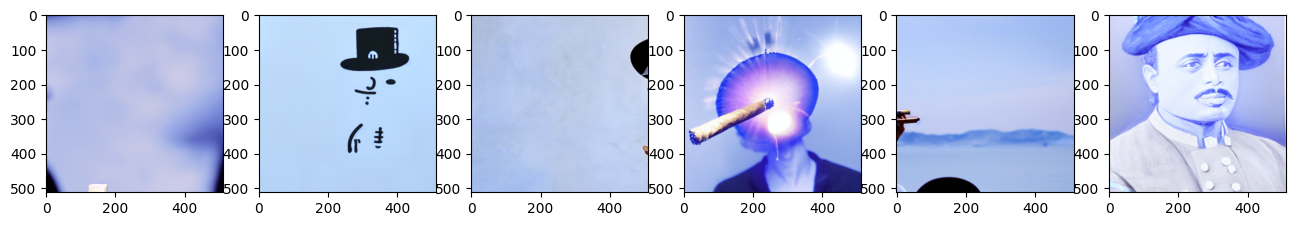

In [19]:
outputs_1 = []
outputs_2 = []
seed_values = [1,2, 3, 4, 5, 6]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance

prompt = " A person wearing a hat and smoking a cigar"

# custom_loss = sobel_loss
custom_loss = blue_loss
custom_loss_scale = 100.0
num_styles = len(style_files)
for cnt in range(num_styles):
    print(cnt, style_files[cnt])
    this_generated_img_1 = generate_image_with_custom_style(prompt,
                                                          style_num = cnt,
                                                          random_seed = seed_values[cnt],
                                                          custom_loss_fn = None,
                                                          custom_loss_scale = custom_loss_scale)
    outputs_1.append(this_generated_img_1)
    this_generated_img_2 = generate_image_with_custom_style(prompt,
                                                          style_num = cnt,
                                                          random_seed = seed_values[cnt],
                                                          custom_loss_fn = custom_loss,
                                                          custom_loss_scale = custom_loss_scale)
    outputs_2.append(this_generated_img_2)


show_images(outputs_1)
show_images(outputs_2)